In [1]:
# Instalar Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Descargar Spark correctamente
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Descomprimir
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz

# Instalar findspark
!pip install -q findspark


spark-3.4.1-bin-hadoop3/
spark-3.4.1-bin-hadoop3/R/
spark-3.4.1-bin-hadoop3/R/lib/
spark-3.4.1-bin-hadoop3/R/lib/sparkr.zip
spark-3.4.1-bin-hadoop3/R/lib/SparkR/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/html/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/html/R.css
spark-3.4.1-bin-hadoop3/R/lib/SparkR/html/00Index.html
spark-3.4.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/aliases.rds
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/AnIndex
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/SparkR.rdx
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/SparkR.rdb
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/paths.rds
spark-3.4.1-bin-hadoop3/R/lib/SparkR/worker/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/worker/worker.R
spark-3.4.1-bin-hadoop3/R/lib/SparkR/worker/daemon.R
spark-3.4.1-bin-hadoop3/R/lib/SparkR/tests/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/tests/testthat/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.4.1-bin-hadoop3/R/lib/S

In [2]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CDMX_Movilidad") \
    .getOrCreate()

spark


In [5]:
df = spark.read.option("header", True).option("inferSchema", True).csv("/content/ecobicis_20230430.csv")

df.printSchema()
df.show(5)


root
 |-- anio: integer (nullable = true)
 |-- mes: string (nullable = true)
 |-- fecha_referencia: date (nullable = true)
 |-- bici: string (nullable = true)
 |-- mins_viaje: double (nullable = true)
 |-- hrs_viaje: double (nullable = true)
 |-- dias_viaje: double (nullable = true)
 |-- distancia_approx: double (nullable = true)

+----+------+----------------+--------+----------+----------------+----------------+------------------+
|anio|   mes|fecha_referencia|    bici|mins_viaje|       hrs_viaje|      dias_viaje|  distancia_approx|
+----+------+----------------+--------+----------+----------------+----------------+------------------+
|2022|Agosto|      2022-08-31|200-6807|    3931.0|65.5166666666667|2.72986111111111|1048.2666666666669|
|2022|Agosto|      2022-08-31|202-2705|    4486.0|74.7666666666667|3.11527777777778|1196.2666666666669|
|2022|Agosto|      2022-08-31|203-1300|    1601.0|26.6833333333333|1.11180555555556|426.93333333333334|
|2022|Agosto|      2022-08-31|203-3454|   1

In [6]:
df.columns


['anio',
 'mes',
 'fecha_referencia',
 'bici',
 'mins_viaje',
 'hrs_viaje',
 'dias_viaje',
 'distancia_approx']

In [12]:
from pyspark.sql.functions import col, hour


df = df.withColumn("hora", col("hrs_viaje").cast("int"))
df.select("hrs_viaje", "hora").show(5)



+----------------+----+
|       hrs_viaje|hora|
+----------------+----+
|65.5166666666667|  65|
|74.7666666666667|  74|
|26.6833333333333|  26|
|168.633333333333| 168|
|98.7333333333333|  98|
+----------------+----+
only showing top 5 rows



In [8]:
viajes_por_hora = df.groupBy("hora") \
                    .count() \
                    .orderBy("hora")

viajes_por_hora.show()


+----+-----+
|hora|count|
+----+-----+
|   0|  102|
|   1|  182|
|   2|  139|
|   3|  137|
|   4|   94|
|   5|  105|
|   6|   64|
|   7|   57|
|   8|   32|
|   9|   29|
|  10|   24|
|  11|   19|
|  12|   15|
|  13|   18|
|  14|   19|
|  15|   17|
|  16|   25|
|  17|   27|
|  18|   39|
|  19|   33|
+----+-----+
only showing top 20 rows



In [13]:
df.columns


['anio',
 'mes',
 'fecha_referencia',
 'bici',
 'mins_viaje',
 'hrs_viaje',
 'dias_viaje',
 'distancia_approx',
 'hora']

In [9]:
bicis_mas_usadas = df.groupBy("bici").count().orderBy("count", ascending=False)
bicis_mas_usadas.show(10)



+--------+-----+
|    bici|count|
+--------+-----+
|259-0552|    9|
|302-5087|    9|
|630-3077|    9|
|310-6630|    9|
|869-5678|    9|
|540-5741|    9|
|464-5834|    9|
|662-2831|    9|
|503-8377|    9|
|374-7771|    9|
+--------+-----+
only showing top 10 rows



In [20]:
bicis_mas_usadas.write.option("header", True).csv("/content/salida_bicis_mas_usadas")


In [21]:


viajes_pd = viajes_por_hora.toPandas()
bicis_pd = bicis_mas_usadas.limit(10).toPandas()


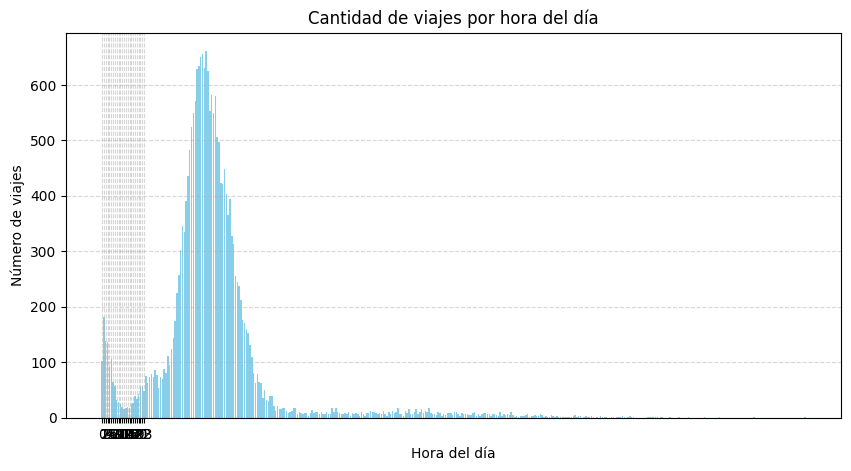

In [22]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.bar(viajes_pd['hora'], viajes_pd['count'], color='skyblue')
plt.title("Cantidad de viajes por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Número de viajes")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


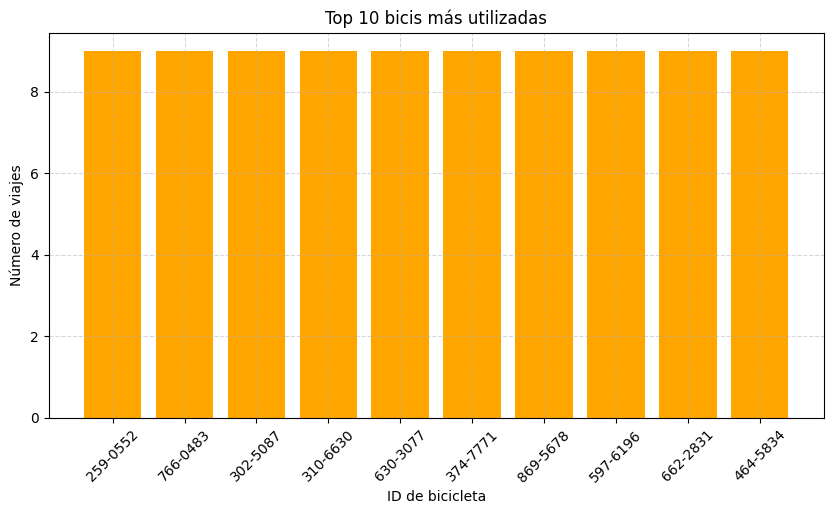

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(bicis_pd['bici'].astype(str), bicis_pd['count'], color='orange')
plt.title("Top 10 bicis más utilizadas")
plt.xlabel("ID de bicicleta")
plt.ylabel("Número de viajes")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
